# The importance of problem framing for supervised predictive maintenance solutions

 - To quickly recap, sensors 1, 5, 6, 10, 16, 18 and 19 held no information related to Remaining Useful Life (RUL);

 - With Linear Regression Model, we reach and RMSE of 31.95;

 - In this step, we'll re-examine our assumption of RUL to improve our accuracy and fit a Support Vector Regression (SVR).

## Loading data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, r2_score

In [3]:
# define filepath to read data
dir_path = './CMAPSSData/'

# define column names for easy indexing
index_names = ['unit_nr', 'time_cycles']
setting_names = ['setting_1', 'setting_2', 'setting_3']
sensor_names = [f's_{i}' for i in range(1,22)]
col_names = index_names + setting_names + sensor_names

# read data
train = pd.read_csv((dir_path+'train_FD001.txt'), sep='\s+', header=None, names=col_names)
test = pd.read_csv((dir_path+'test_FD001.txt'), sep='\s+', header=None, names=col_names)
y_test = pd.read_csv((dir_path+'RUL_FD001.txt'), sep='\s+', header=None, names=['RUL'])


In [4]:
# inspect first few rows
train.head()

,unit_nr,time_cycles,setting_1,setting_2,setting_3,s_1,s_2,s_3,s_4,s_5,...,s_12,s_13,s_14,s_15,s_16,s_17,s_18,s_19,s_20,s_21
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,521.66,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,522.28,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,522.42,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,522.86,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,522.19,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044


In [5]:
def add_remaining_useful_life(df):

    # Get the total number of cycles for each unique
    max_cycle = df.groupby("unit_nr").agg({
        "time_cycles": "max"
    }).reset_index()

    max_cycle.rename(columns={"time_cycles": "max_cycle"}, inplace=True)

    # Merge the max cycle back into the original frame
    result_frame = df.merge(max_cycle, on='unit_nr', how="left")

    # Calculate remaining useful life for each row
    remaining_useful_life = result_frame['max_cycle'] - result_frame['time_cycles']
    result_frame['RUL'] = remaining_useful_life

    # drop max_cycle as it's no longer needed
    result_frame = result_frame.drop("max_cycle", axis=1)
    return result_frame

In [6]:
train = add_remaining_useful_life(train)
train

,unit_nr,time_cycles,setting_1,setting_2,setting_3,s_1,s_2,s_3,s_4,s_5,...,s_13,s_14,s_15,s_16,s_17,s_18,s_19,s_20,s_21,RUL
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190,191
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236,190
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442,189
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739,188
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044,187
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20626,100,196,-0.0004,-0.0003,100.0,518.67,643.49,1597.98,1428.63,14.62,...,2388.26,8137.60,8.4956,0.03,397,2388,100.0,38.49,22.9735,4
20627,100,197,-0.0016,-0.0005,100.0,518.67,643.54,1604.50,1433.58,14.62,...,2388.22,8136.50,8.5139,0.03,395,2388,100.0,38.30,23.1594,3
20628,100,198,0.0004,0.0000,100.0,518.67,643.42,1602.46,1428.18,14.62,...,2388.24,8141.05,8.5646,0.03,398,2388,100.0,38.44,22.9333,2
20629,100,199,-0.0011,0.0003,100.0,518.67,643.23,1605.26,1426.53,14.62,...,2388.23,8139.29,8.5389,0.03,395,2388,100.0,38.29,23.0640,1


In [10]:
# Prepare the data by dropping the columns which hold no useful information
drop_sensors = [f's_{i}' for i in [1,5,6,10,16,18,19]]
drop_labels = index_names+setting_names+drop_sensors

X_train = train.drop(drop_labels, axis=1)
y_train = X_train.pop('RUL')

#Since the true RUL values for the test set are only provided for the last time cycle of each engine, the test set is subsetted to represent the same
X_test = test.groupby('unit_nr').last().reset_index().drop(drop_labels, axis=1)

In [11]:
X_test

,s_2,s_3,s_4,s_7,s_8,s_9,s_11,s_12,s_13,s_14,s_15,s_17,s_20,s_21
0,642.58,1581.22,1398.91,554.42,2388.08,9056.40,47.23,521.79,2388.06,8130.11,8.4024,393,38.81,23.3552
1,642.55,1586.59,1410.83,553.52,2388.10,9044.77,47.67,521.74,2388.09,8126.90,8.4505,391,38.81,23.2618
2,642.88,1589.75,1418.89,552.59,2388.16,9049.26,47.88,520.83,2388.14,8131.46,8.4119,395,38.93,23.2740
3,642.78,1594.53,1406.88,552.64,2388.13,9051.30,47.65,521.88,2388.11,8133.64,8.4634,395,38.58,23.2581
4,642.27,1589.94,1419.36,553.29,2388.10,9053.99,47.46,521.00,2388.15,8125.74,8.4362,394,38.75,23.4117
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,642.30,1590.88,1397.94,553.99,2388.03,9062.41,47.14,522.30,2388.01,8148.24,8.4110,391,38.96,23.4606
96,642.59,1582.96,1410.92,554.05,2388.06,9076.36,47.38,521.58,2388.06,8155.48,8.4500,395,38.61,23.2953
97,642.68,1599.51,1415.47,553.44,2388.13,9062.34,47.66,521.53,2388.09,8146.39,8.4235,394,38.76,23.3608
98,642.00,1585.03,1397.98,554.75,2388.01,9067.16,47.26,521.82,2388.02,8150.38,8.4003,391,38.95,23.3595


In [12]:
# Function to evaluate model performance
def evaluate(y_true, y_pred, label='test'):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    variance = r2_score(y_true, y_pred)
    print(f"{label} set RMSE: {rmse}, R2-Score: {variance}")

In [13]:
# Linear Regression baseline model

# create and fit model
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

# Predict and evaluate
y_pred_train = lr_model.predict(X_train)
evaluate(y_train, y_pred_train, label='train')

y_pred_test = lr_model.predict(X_test)
evaluate(y_test, y_pred_test)

train set RMSE: 44.66819159545431, R2-Score: 0.5794486527796758
test set RMSE: 31.952633027741687, R2-Score: 0.4087736807657457


### Re-examining RUL
 - In the baseline model, we assume that RUL decline linearly over time. This assumption may influence our overall model performance;

 - The behaviour of the sensors isn't linear, in fact many sensors seem rather constant in the beginning. This is because the engines only develop a fault over time;

 - The bend in the curve of the signal is the first bit of information provided to us that the engine is degrading and the first time it is reasonable to assume RUL almost linearly declining;

 - Then, instead of having our RUL decline linearly, we define our RUL to start out as a constant and only decline linearly after some time.

 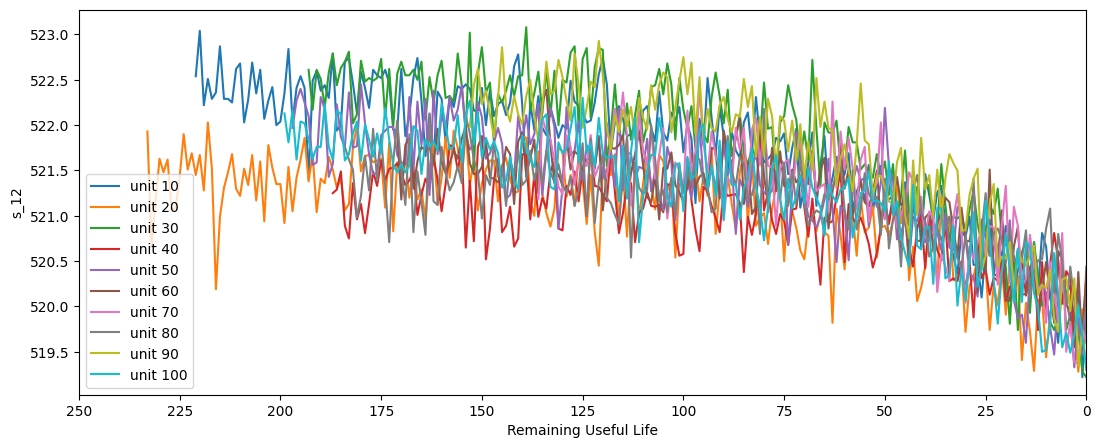

In [17]:
# Clipped RUL
y_train_clipped = y_train.clip(upper=125)

# create and fit model
lr_model = LinearRegression()
lr_model.fit(X_train, y_train_clipped)

#predict and evaluate
y_pred_train = lr_model.predict(X_train)
evaluate(y_train_clipped, y_pred_train, label='train')

y_pred_test = lr_model.predict(X_test)
evaluate(y_test, y_pred_test)

train set RMSE: 21.491018701515106, R2-Score: 0.7340432868050523
test set RMSE: 21.900213406891275, R2-Score: 0.7222608196546048


## Support Vector Regression

In [18]:
#create and fit SVR model
svr_model = SVR(kernel='linear')
svr_model.fit(X_train, y_train_clipped)

#predict and evaluate
y_pred_train = svr_model.predict(X_train)
evaluate(y_train_clipped, y_pred_train, label='train')

y_pred_test = svr_model.predict(X_test)
evaluate(y_test, y_pred_test)

#### Consideration
 
 - The RMSE's are much worse than our Linear Regression with clipped RUL;

 - It's a good way improve our model by scaling our features;

 - SVR's work by comparing distances between feature vectors.

### Scaling

 - Sklearn's MinMaxScaler can be used to create a scaler fitted to our train data;

In [ ]:
# Scaling
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# SVM regression + clipped RUL + scaled
svr_model = SVR(kernel='linear')
svr_model.fit(X_train_scaled, y_train_clipped)

# Predict and evaluate
y_pred_train = svr_model.predict(X_train_scaled)
evaluate(y_train_clipped, y_pred_train, 'train')

y_pred_test = svr_model.predict(X_test_scaled)
evaluate(y_test, y_pred_test)